# Import library


In [42]:
import numpy as np
import pandas as pd
# from PFPM import Mining_Periodic_Frequent_Patterns
import ast
import matplotlib.pyplot as plt
from collections import Counter
import time


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [44]:
import itertools


def Calculate_periods(itemsets, carts, gamma):
    """Calculates periods of an itemset in a carts database."""
    periods_dir = {}
    for itemset in itemsets:
        occurrences = [i for i, cart in enumerate(carts) if set(itemset).issubset(cart)]
        periods = [
            occurrences[i + 1] - occurrences[i] for i in range(len(occurrences) - 1)
        ]

        first_period = 1
        if occurrences and occurrences[0] != 0:
            first_period = occurrences[0] + first_period

        periods.insert(0, first_period)
        if occurrences:
            last_period = len(carts) - 1 - occurrences[-1]
            periods.append(last_period)

        support = len(periods) - 1
        if support >= gamma:
            periods_dir[itemset] = periods

    return periods_dir

def Calculate_average_minimum_maximum_periodicity(period):
    """Calculates average, minimum, and maximum periodicity."""
    if not period:
        return 0, 0, 0
    avg_period = sum(period) / len(period)
    valid_periods = period[1:-1]

    if valid_periods:
        min_period = min(valid_periods)
    else:
        min_period = period[0] if period else 0
    max_period = max(period) if period else 0
    return avg_period, min_period, max_period


def get_itemsets(unique_item, numCombinations):
    """ combinations item"""
    itemsets = []
    itemsets.extend(itertools.combinations(set(unique_item), numCombinations))
    return itemsets


def Periodic_Frequent_Patterns_Mining(carts, minsup, minPer, maxPer, minAvg, maxAvg):
    """Implements the PFPM algorithm."""
    periodic_itemsets = []
    if carts is not None:
        gamma = (len(carts) / maxAvg) - 1

        unique_item = set(item for sublist in carts for item in sublist)

        for numCombinations in range(1, len(unique_item) - 1):

            itemsets = get_itemsets(unique_item, numCombinations)

            periods_dir = Calculate_periods(itemsets, carts, gamma)

            unique_item = set()

            for id in periods_dir:
                period = periods_dir[id]
                avg_period, min_period, max_period = Calculate_average_minimum_maximum_periodicity(period)
                support = len(period) - 1

                if support >= minsup:
                    if (
                        min_period >= minPer
                        and max_period <= maxPer
                        and minAvg <= avg_period <= maxAvg
                    ):
                        periodic_itemsets.append(
                            (id, support, min_period, max_period, avg_period)
                        )
                        unique_item.add(id)
            if len(unique_item) < numCombinations:
                break
    return periodic_itemsets


# Prepare convert code and item

In [45]:
def visualize_results(result, category_codes_dataset):
  columns = ['item', 'support', 'min_period', 'max_period', 'avg_period']
  df = pd.DataFrame(result, columns=columns)

  # Convert tuples in 'item' column to strings
  df['item'] = df['item'].apply(lambda x: ''.join(x))

  df['item'] = df['item'].apply(lambda x: x.replace('(', '').replace(')', ''))


  merged_df = pd.merge(df, category_codes_dataset, left_on='item', right_on='Code').drop(columns=['item'])[['Code', 'Category', 'support', 'min_period', 'max_period', 'avg_period']]
  # merged_df = merged_df['Category', 'support', 'min_period', 'max_period', 'avg_period']
  return merged_df

# Dataset 1

## Prepare dataset 1


In [46]:
category_codes_dataset1 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/category_codes_dataset1.csv")

In [47]:
dataset1 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/dataset1.csv")

In [48]:
dataset1.head()

,Date,Description
0,2010-12-12 11:07:00,"['C3099', 'C3059', 'C969', 'C3059', 'C646', 'C..."
1,2010-12-12 11:17:00,"['C2761', 'C630', 'C226', 'C1035', 'C3520', 'C..."
2,2010-12-12 11:26:00,"['C45', 'C585', 'C2557', 'C2686', 'C1334', 'C2..."
3,2010-12-12 11:26:00,"['C2009', 'C3562', 'C1589', 'C1873', 'C1509', ..."
4,2010-12-12 11:37:00,"['C1712', 'C2814', 'C383', 'C1649', 'C1118', '..."


In [49]:
dataset1['Date'] = pd.to_datetime(dataset1['Date'])

df_spring = dataset1[(dataset1['Date'].dt.month >= 3) & (dataset1['Date'].dt.month <= 5) & (dataset1['Date'].dt.year == 2011)]
df_summer = dataset1[(dataset1['Date'].dt.month >= 6) & (dataset1['Date'].dt.month <= 8) & (dataset1['Date'].dt.year == 2011)]
df_autumn = dataset1[(dataset1['Date'].dt.month >= 9) & (dataset1['Date'].dt.month <= 11) & (dataset1['Date'].dt.year == 2011)]
df_winter = dataset1[((dataset1['Date'].dt.month >= 12) | (dataset1['Date'].dt.month <= 2)) & (dataset1['Date'].dt.year == 2011)]

In [50]:
df_spring[:5]

,Date,Description
2247,2011-03-01 08:30:00,"['C1054', 'C106', 'C3625', 'C1988', 'C3416', '..."
2248,2011-03-01 08:35:00,"['C1155', 'C311', 'C1758', 'C776', 'C3259', 'C..."
2249,2011-03-01 08:49:00,"['C3001', 'C1758', 'C679', 'C1113', 'C3060', '..."
2250,2011-03-01 09:03:00,"['C2300', 'C2922', 'C3056', 'C2337', 'C3039', ..."
2251,2011-03-01 09:22:00,"['C1744', 'C467', 'C3611']"


In [51]:
# winter_dataset = df_winter["Description"].apply(ast.literal_eval).apply(lambda x: x[-10:]).tolist()

winter_dataset = df_winter["Description"].apply(ast.literal_eval).tolist()
autumn_dataset = df_autumn["Description"].apply(ast.literal_eval).tolist()
summer_dataset = df_summer["Description"].apply(ast.literal_eval).tolist()
spring_dataset = df_spring["Description"].apply(ast.literal_eval).tolist()

In [52]:
sorted_winter_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in winter_dataset]
sorted_autumn_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in autumn_dataset]
sorted_summer_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in summer_dataset]
sorted_spring_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in spring_dataset]

## Traning

---



In [53]:
start_time = time.time()

In [54]:
minsup = 150
minPer = 1
maxPer = 100
minAvg = 1
maxAvg = 30


In [55]:
Periodic_Frequent_spring = Periodic_Frequent_Patterns_Mining(sorted_spring_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_spring)

Periodic_Frequent_spring_df = visualize_results(Periodic_Frequent_spring, category_codes_dataset1)

print(Periodic_Frequent_spring_df.to_string(index=False))

 Code                            Category  support  min_period  max_period  avg_period
C1334          COOK WITH WINE METAL SIGN       189           1          83   18.757895
C3376  WHITE HANGING HEART T-LIGHT HOLDER      511           1          37    6.960938
C2191             LUNCH BAG RED RETROSPOT      319           1          80   11.137500
C2485        SET OF 4 PANTRY JELLY MOULDS      310           1          58   11.459807
 C748     NATURAL SLATE HEART CHALKBOARD       226           1          86   15.700441
 C903                 DOORMAT NEW ENGLAND      161           1          92   22.000000
C1035             JUMBO BAG RED RETROSPOT      336           1          65   10.575668
C2988         GIN + TONIC DIET METAL SIGN      172           1         100   20.601156
 C560                       PARTY BUNTING      473           1          49    7.518987
C1382          LUNCH BAG SPACEBOY DESIGN       222           1          95   15.982063
C1989 COLOUR GLASS T-LIGHT HOLDER HANGING  

In [56]:
Periodic_Frequent_summer = Periodic_Frequent_Patterns_Mining(sorted_summer_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_summer)

Periodic_Frequent_summer_df = visualize_results(Periodic_Frequent_summer, category_codes_dataset1)

print(Periodic_Frequent_summer_df.to_string(index=False))

 Code                            Category  support  min_period  max_period  avg_period
C2990              JAM MAKING SET PRINTED      193           1          85   18.159794
C3376  WHITE HANGING HEART T-LIGHT HOLDER      386           1          80    9.103359
C2191             LUNCH BAG RED RETROSPOT      375           1          63    9.369681
C2485        SET OF 4 PANTRY JELLY MOULDS      227           1          74   15.451754
 C748     NATURAL SLATE HEART CHALKBOARD       197           1          98   17.792929
C1035             JUMBO BAG RED RETROSPOT      404           1          40    8.698765
 C560                       PARTY BUNTING      450           1          53    7.811530
C1382          LUNCH BAG SPACEBOY DESIGN       271           1          66   12.952206
C2592                  JUMBO BAG ALPHABET      260           1          85   13.498084
C3321   GARDENERS KNEELING PAD KEEP CALM       259           1          87   13.550000
 C364             PAPER BUNTING RETROSPOT  

In [57]:
Periodic_Frequent_autumn = Periodic_Frequent_Patterns_Mining(sorted_autumn_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_autumn)

Periodic_Frequent_autumn_df = visualize_results(Periodic_Frequent_autumn, category_codes_dataset1)

print(Periodic_Frequent_autumn_df.to_string(index=False))

 Code                            Category  support  min_period  max_period  avg_period
C3456        SCOTTIE DOG HOT WATER BOTTLE      363           1          77   15.530220
C1377      PANTRY MAGNETIC  SHOPPING LIST      229           1          96   24.578261
C1004                      POPCORN HOLDER      398           1          75   14.167920
C1913   HOT WATER BOTTLE TEA AND SYMPATHY      391           1          97   14.420918
C1035             JUMBO BAG RED RETROSPOT      549           1          75   10.278182
C2541          CHOCOLATE HOT WATER BOTTLE      400           1          69   14.097257
C2434               LOVE HOT WATER BOTTLE      404           1          99   13.958025
 C601       BAKING SET 9 PIECE RETROSPOT       395           1          90   14.275253
C3337 SET OF 20 VINTAGE CHRISTMAS NAPKINS      339           1          98   16.626471
C2886              HAND WARMER OWL DESIGN      410           1          82   13.754258
C1692          HOT WATER BOTTLE KEEP CALM  

In [58]:

Periodic_Frequent_winter = Periodic_Frequent_Patterns_Mining(sorted_winter_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_winter)

Periodic_Frequent_winter_df = visualize_results(Periodic_Frequent_winter, category_codes_dataset1)

print(Periodic_Frequent_winter_df.to_string(index=False))

 Code                           Category  support  min_period  max_period  avg_period
C2990             JAM MAKING SET PRINTED      168           1          70   14.751479
C3376 WHITE HANGING HEART T-LIGHT HOLDER      322           1          59    7.718266
C2191            LUNCH BAG RED RETROSPOT      172           1          73   14.410405
 C748    NATURAL SLATE HEART CHALKBOARD       197           1          99   12.590909
C2009           JAM MAKING SET WITH JARS      173           1         100   14.327586
C1594  SET OF 3 CAKE TINS PANTRY DESIGN       284           1          94    8.747368
C1968          ALARM CLOCK BAKELIKE RED       150           1          90   16.509934
C3642  SET OF 6 SPICE TINS PANTRY DESIGN      190           1          96   13.052356
C1124           REGENCY CAKESTAND 3 TIER      260           1          49    9.551724
C3533      ASSORTED COLOUR BIRD ORNAMENT      177           1          83   14.005618
C3358       PLEASE ONE PERSON METAL SIGN      160     

In [59]:
end_time = time.time()
# Tính toán thời gian thực thi
execution_time = end_time - start_time
print(f"Thời gian thực thi: {execution_time} giây")

Thời gian thực thi: 110.26858067512512 giây


In [60]:
minsup = 500
minPer = 1
maxPer = 170
minAvg = 1
maxAvg = 40

dataset = dataset1["Description"].apply(ast.literal_eval).tolist()
Periodic_Frequent_All = Periodic_Frequent_Patterns_Mining(dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_All)

Periodic_Frequent_all_df = visualize_results(Periodic_Frequent_All, category_codes_dataset1)

print(Periodic_Frequent_all_df.to_string(index=False))

 Code                            Category  support  min_period  max_period  avg_period
C2717                DOLLY GIRL LUNCH BOX      587           1         151   26.714286
C3376  WHITE HANGING HEART T-LIGHT HOLDER     1821           1         108    8.621295
C3417                 SPACEBOY LUNCH BOX       675           1         157   23.236686
C2191             LUNCH BAG RED RETROSPOT     1252           1         123   12.536313
 C748     NATURAL SLATE HEART CHALKBOARD       927           1         125   16.926724
C1035             JUMBO BAG RED RETROSPOT     1524           1         101   10.300328
C2636           ALARM CLOCK BAKELIKE PINK      581           1         165   26.989691
C1382          LUNCH BAG SPACEBOY DESIGN       961           1         134   16.328482
C2009            JAM MAKING SET WITH JARS      828           1         164   18.948130
C1084         RED RETROSPOT CHARLOTTE BAG      717           1         159   21.877437
C1968           ALARM CLOCK BAKELIKE RED   

## Analysis OutPut


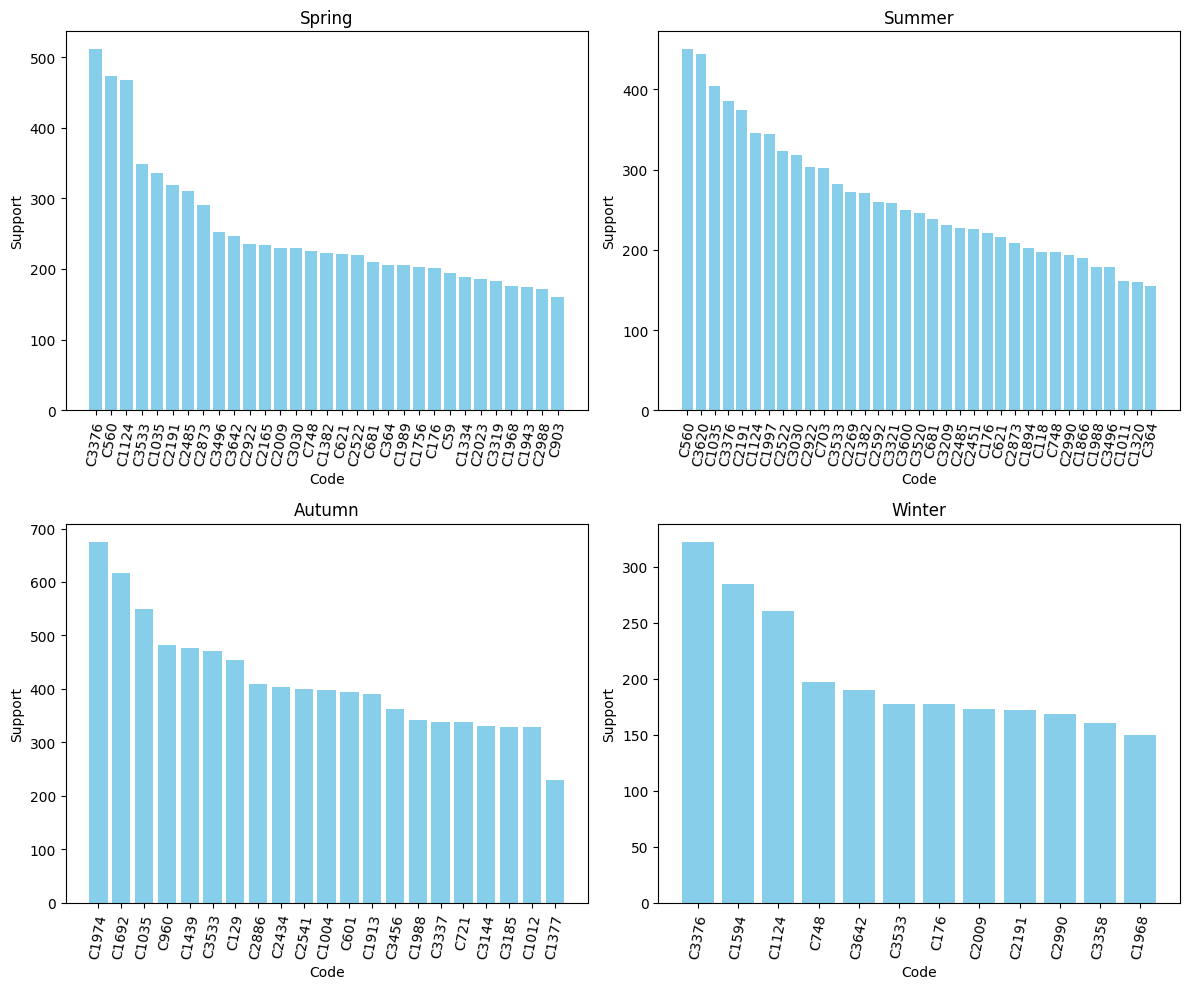

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [Periodic_Frequent_spring_df, Periodic_Frequent_summer_df, Periodic_Frequent_autumn_df, Periodic_Frequent_winter_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='support', ascending=False))
    ax.bar(df['Code'], df['support'], color='skyblue')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Support')
    ax.tick_params(axis='x', rotation=80)
plt.tight_layout()
plt.show()

## Evaluate model

In [62]:
# ## winter
winter_dataset_counts = Counter([item for sublist in winter_dataset for item in sublist]).most_common(10)
winter_dataset_counts_df = pd.DataFrame(winter_dataset_counts, columns=['Code', 'Quantity'])


# ## autumn
autumn_dataset_counts = Counter([item for sublist in autumn_dataset for item in sublist]).most_common(10)
autumn_dataset_counts_df = pd.DataFrame(autumn_dataset_counts, columns=['Code', 'Quantity'])


## summer
summer_dataset_counts = Counter([item for sublist in summer_dataset for item in sublist]).most_common(10)
summer_dataset_counts_df = pd.DataFrame(summer_dataset_counts, columns=['Code', 'Quantity'])


### spring
spring_dataset_counts = Counter([item for sublist in spring_dataset for item in sublist]).most_common(10)
spring_dataset_counts_df = pd.DataFrame(spring_dataset_counts, columns=['Code', 'Quantity'])



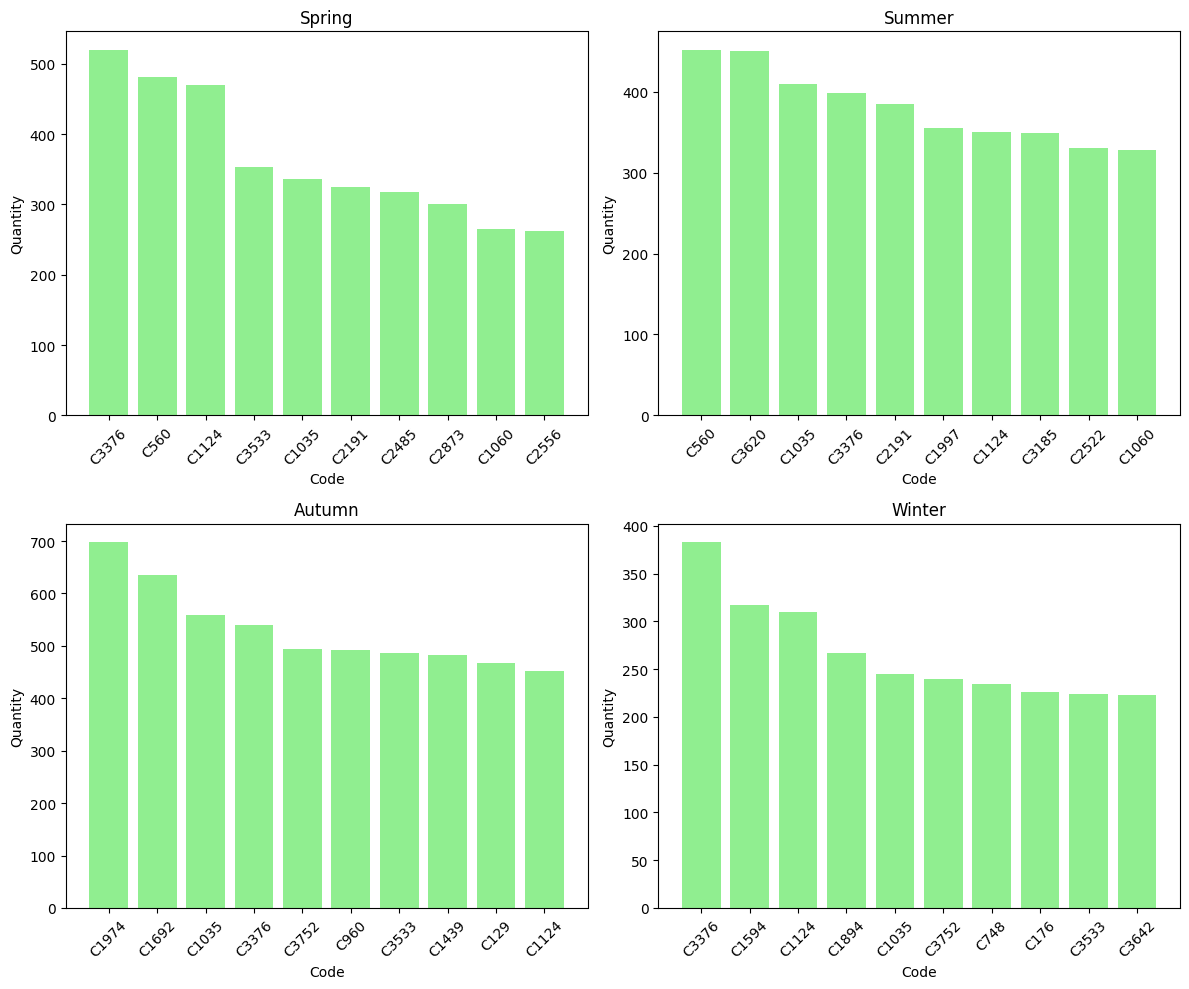

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [spring_dataset_counts_df, summer_dataset_counts_df, autumn_dataset_counts_df, winter_dataset_counts_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Quantity', ascending=False))
    ax.bar(df['Code'], df['Quantity'], color='lightgreen')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Quantity')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

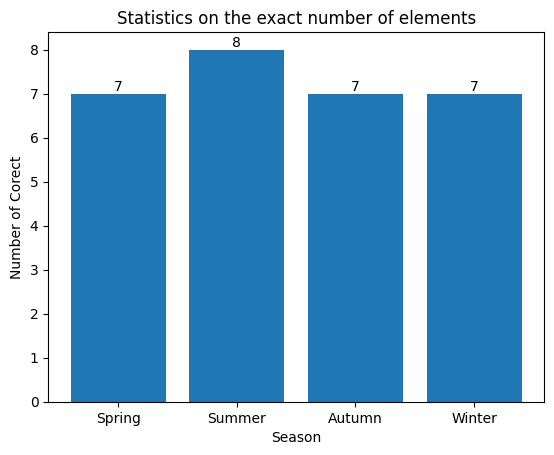

In [64]:
confident_spring_2011 = list(set(winter_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_spring_df['Code'])))

confident_summer_2011 = list(set(summer_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_summer_df['Code'])))

confident_autumn_2011 = list(set(autumn_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_autumn_df['Code'])))

confident_winter_2011 = list(set(winter_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_winter_df['Code'])))


counts = [len(confident_spring_2011), len(confident_summer_2011), len(confident_autumn_2011), len(confident_winter_2011)]

# Vẽ biểu đồ cột
plt.bar(['Spring', 'Summer', 'Autumn', 'Winter'], counts)

# Add labels on top of each bar
plt.bar_label(plt.gca().containers[0])

plt.xlabel('Season')
plt.ylabel('Number of Corect')
plt.title('Statistics on the exact number of elements')
plt.show()


confident_dataset1 = sum([len(confident_spring_2011), len(confident_summer_2011), len(confident_autumn_2011), len(confident_winter_2011)]) /  4

In [65]:
confident_dataset1

7.25

# Dataset 2

## Prepare dataset 2

In [66]:
category_codes_dataset2 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/category_codes_dataset2.csv")

In [67]:
dataset2 = pd.read_csv("/content/drive/MyDrive/IT Project/Code/dataset/dataset2.csv")

In [68]:
dataset2.head()

,Date,Description
0,2022-01-02,"['C491', 'C263', 'C3276', 'C1808', 'C425', 'C3..."
1,2022-01-03,"['C2657', 'C272', 'C3272']"
2,2022-01-04,"['C3319', 'C1851', 'C263', 'C1808', 'C2481', '..."
3,2022-01-04,"['C3705', 'C767', 'C3051']"
4,2022-01-04,"['C1254', 'C1842', 'C985', 'C1492', 'C432', 'C..."


In [69]:
dataset2['Date'] = pd.to_datetime(dataset2['Date'])

df_spring = dataset2[(dataset2['Date'].dt.month >= 3) & (dataset2['Date'].dt.month <= 5)]
df_summer = dataset2[(dataset2['Date'].dt.month >= 6) & (dataset2['Date'].dt.month <= 8)]
df_autumn = dataset2[(dataset2['Date'].dt.month >= 9) & (dataset2['Date'].dt.month <= 11)]
df_winter = dataset2[(dataset2['Date'].dt.month >= 12) | (dataset2['Date'].dt.month <= 2)]


In [70]:
winter_dataset = df_winter["Description"].apply(ast.literal_eval).tolist()
autumn_dataset = df_autumn["Description"].apply(ast.literal_eval).tolist()
summer_dataset = df_summer["Description"].apply(ast.literal_eval).tolist()
spring_dataset = df_spring["Description"].apply(ast.literal_eval).tolist()

In [71]:
sorted_winter_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in winter_dataset]
sorted_autumn_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in autumn_dataset]
sorted_summer_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in summer_dataset]
sorted_spring_dataset = [sorted(sublist, key=lambda item: int(item.split("C")[1])) for sublist in spring_dataset]

## Traning

In [72]:
start_time = time.time()

In [73]:
minsup = 10
minPer = 1
maxPer = 40
minAvg = 1
maxAvg = 20


In [74]:
Periodic_Frequent_spring = Periodic_Frequent_Patterns_Mining(sorted_spring_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_spring)

Periodic_Frequent_spring_df = visualize_results(Periodic_Frequent_spring, category_codes_dataset2)

print(Periodic_Frequent_spring_df.to_string(index=False))


 Code                              Category  support  min_period  max_period  avg_period
 C281                 CUCHUCO A GRANEL*KILO       17           1          32   13.888889
C2408          LECHE SAN FERNANDO  *1100 ML       13          12          25   17.857143
 C788                                 LIMON       20           1          32   11.904762
C1382                         PAPA AMARILLA       29           1          27    8.333333
C2701    PAPAS RIZADAS YUPI  MAYONESA *250G       12          15          35   19.230769
C1247 MAIZ TRILLADO BLANCO A GRANEL Y *KILO       19           1          31   12.500000
C2166                          ARVEJA VERDE       24           1          27   10.000000
C1910                       YUPI QUESO *44G       12          13          26   19.230769
C3204              PQT RIZADA LIMON X 45 GR       13          13          26   17.857143
  C54                             ZANAHORIA       25           1          27    9.615385
C1471                

In [75]:
Periodic_Frequent_summer = Periodic_Frequent_Patterns_Mining(sorted_summer_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_summer)
Periodic_Frequent_summer_df = visualize_results(Periodic_Frequent_summer, category_codes_dataset2)

print(Periodic_Frequent_summer_df.to_string(index=False))


 Code                              Category  support  min_period  max_period  avg_period
C2547 PESCADO CABEZA DE TILAPIA NEGRA *KILO       14           1          35   15.400000
C2969                         TOMATE CHONTO       13           2          37   16.500000
 C956                   YUPI HORNEADOS *44G       13          12          24   16.500000
C3700       PAPAS RIZADAS MAYONESA X 31 GM.       13          12          24   16.500000
C3319                                  LULO       13           2          37   16.500000
C3677                                  YUCA       17           2          35   12.833333
C2214                       TOMATE DE ARBOL       17           2          37   12.833333
C3716                                PAPAYA       21           1          38   10.500000
C3229            TOZINETAS FRED YUPI * 25 G       13          12          24   16.500000
C1534           PQT RIZADA MAYONESA X 45 GR       13          12          24   16.500000
C3721                

In [76]:
Periodic_Frequent_autumn = Periodic_Frequent_Patterns_Mining(sorted_autumn_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_autumn)
Periodic_Frequent_autumn_df = visualize_results(Periodic_Frequent_autumn, category_codes_dataset2)

print(Periodic_Frequent_autumn_df.to_string(index=False))

 Code                           Category  support  min_period  max_period  avg_period
C3323                            BATAVIA       15           2          25    9.750000
 C281              CUCHUCO A GRANEL*KILO       10           4          32   14.181818
 C956                YUPI HORNEADOS *44G       10           8          28   14.181818
C2611               MAIZ PERGAMINO VALLE       11           1          25   13.000000
C3716                             PAPAYA       14           4          25   10.400000
C3721                TOSTIEMPANADAS YUPI       11           8          22   13.000000
C1382                      PAPA AMARILLA       17           1          24    8.666667
C2701 PAPAS RIZADAS YUPI  MAYONESA *250G       10           8          22   14.181818
 C263                         PAPA PARDA       14           3          24   10.400000
C2487                      BULTO DE PAPA       11           5          34   13.000000
C2444       LECHE SAN FERNANDO  X 400 ML       10     

In [77]:
Periodic_Frequent_winter = Periodic_Frequent_Patterns_Mining(sorted_winter_dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_winter)
Periodic_Frequent_winter_df = visualize_results(Periodic_Frequent_winter, category_codes_dataset2)

print(Periodic_Frequent_winter_df.to_string(index=False))

 Code                                  Category  support  min_period  max_period  avg_period
 C281                     CUCHUCO A GRANEL*KILO       11           2          37   17.166667
C2408              LECHE SAN FERNANDO  *1100 ML       12          11          23   15.846154
C3700           PAPAS RIZADAS MAYONESA X 31 GM.       12          11          27   15.846154
C2611                      MAIZ PERGAMINO VALLE       19           2          30   10.300000
C2636                   PESCADO BOCACHICO *KILO       11           1          40   17.166667
C3716                                    PAPAYA       19           4          37   10.300000
C3229                TOZINETAS FRED YUPI * 25 G       11          11          37   17.166667
C1534               PQT RIZADA MAYONESA X 45 GR       11          11          34   17.166667
C1382                             PAPA AMARILLA       27           1          34    7.357143
C3500                              FRIJOL VERDE       16           2  

In [78]:
end_time = time.time()
# Tính toán thời gian thực thi
execution_time = end_time - start_time
print(f"Thời gian thực thi: {execution_time} giây")

Thời gian thực thi: 3.357146978378296 giây


In [79]:
minsup = 50
minPer = 1
maxPer = 70
minAvg = 1
maxAvg = 20

dataset = dataset2["Description"].apply(ast.literal_eval).tolist()
Periodic_Frequent_All = Periodic_Frequent_Patterns_Mining(dataset, minsup, minPer, maxPer, minAvg, maxAvg)
len(Periodic_Frequent_All)

Periodic_Frequent_All_df = visualize_results(Periodic_Frequent_All, category_codes_dataset2)

print(Periodic_Frequent_All_df.to_string(index=False))

 Code             Category  support  min_period  max_period  avg_period
 C788                LIMON       64           1          55   12.969231
C1382        PAPA AMARILLA       94           1          36    8.873684
C1322              GUAYABA       59           1          52   14.050000
  C54            ZANAHORIA       82           1          36   10.156627
C3323              BATAVIA       82           1          55   10.156627
C2611 MAIZ PERGAMINO VALLE       57           1          59   14.534483
C3716               PAPAYA       82           1          38   10.156627
C3500         FRIJOL VERDE       53           1          54   15.611111
C3009        FRESA BANDEJA       53           1          57   15.611111
 C263           PAPA PARDA       52           1          69   15.905660
 C425            APIO KILO       51           1          57   16.211538
 C644            REMOLACHA       60           1          45   13.819672
C1934                BAGRE       76           1          54   10

## Analysis Output

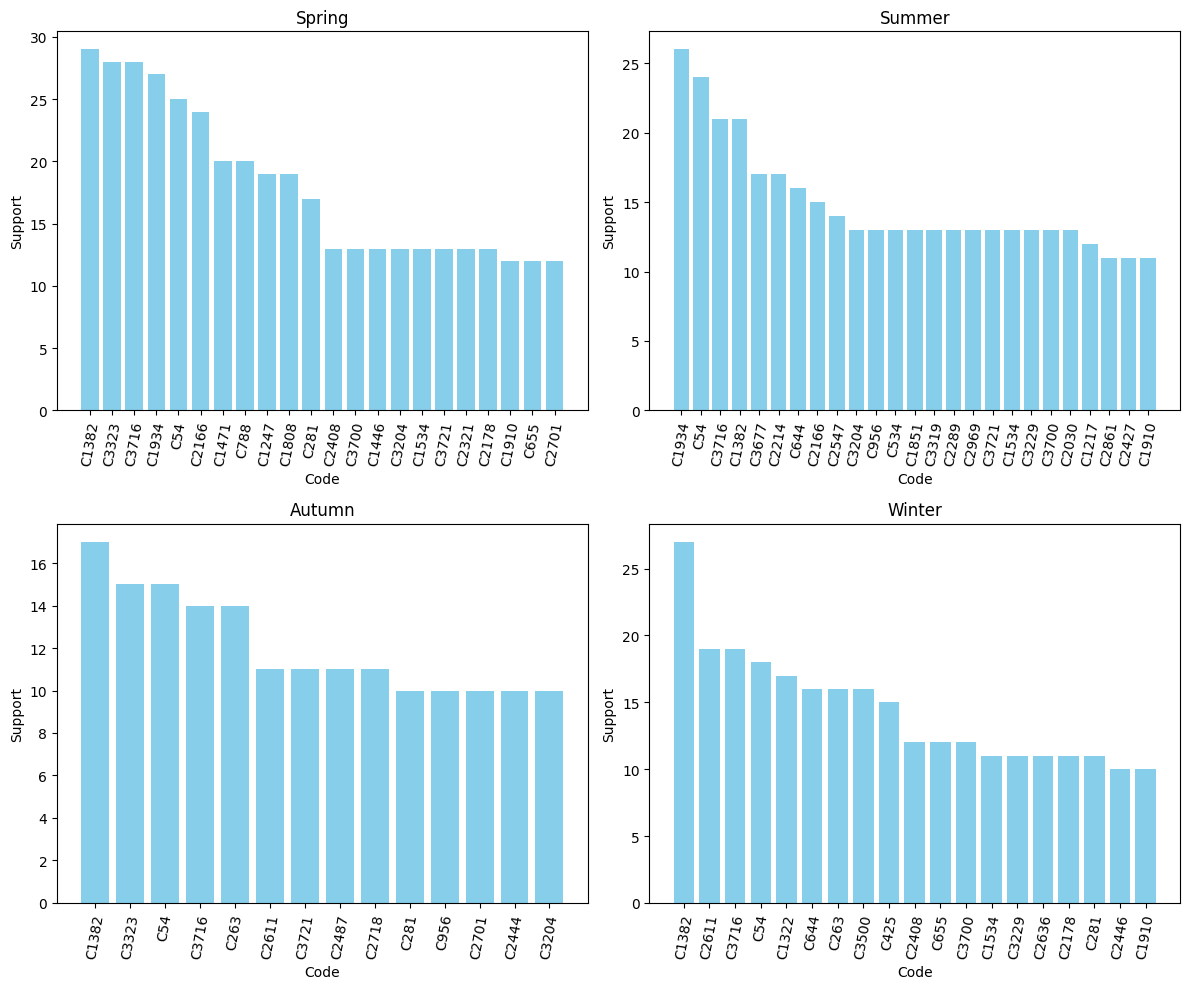

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [Periodic_Frequent_spring_df, Periodic_Frequent_summer_df, Periodic_Frequent_autumn_df, Periodic_Frequent_winter_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='support', ascending=False))
    ax.bar(df['Code'], df['support'], color='skyblue')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Support')
    ax.tick_params(axis='x', rotation=80)
plt.tight_layout()
plt.show()

## Evaluate

In [81]:
# ## winter
winter_dataset_counts = Counter([item for sublist in winter_dataset for item in sublist]).most_common(10)
winter_dataset_counts_df = pd.DataFrame(winter_dataset_counts, columns=['Code', 'Quantity'])


# ## autumn
autumn_dataset_counts = Counter([item for sublist in autumn_dataset for item in sublist]).most_common(10)
autumn_dataset_counts_df = pd.DataFrame(autumn_dataset_counts, columns=['Code', 'Quantity'])


## summer
summer_dataset_counts = Counter([item for sublist in summer_dataset for item in sublist]).most_common(10)
summer_dataset_counts_df = pd.DataFrame(summer_dataset_counts, columns=['Code', 'Quantity'])


### spring
spring_dataset_counts = Counter([item for sublist in spring_dataset for item in sublist]).most_common(10)
spring_dataset_counts_df = pd.DataFrame(spring_dataset_counts, columns=['Code', 'Quantity'])



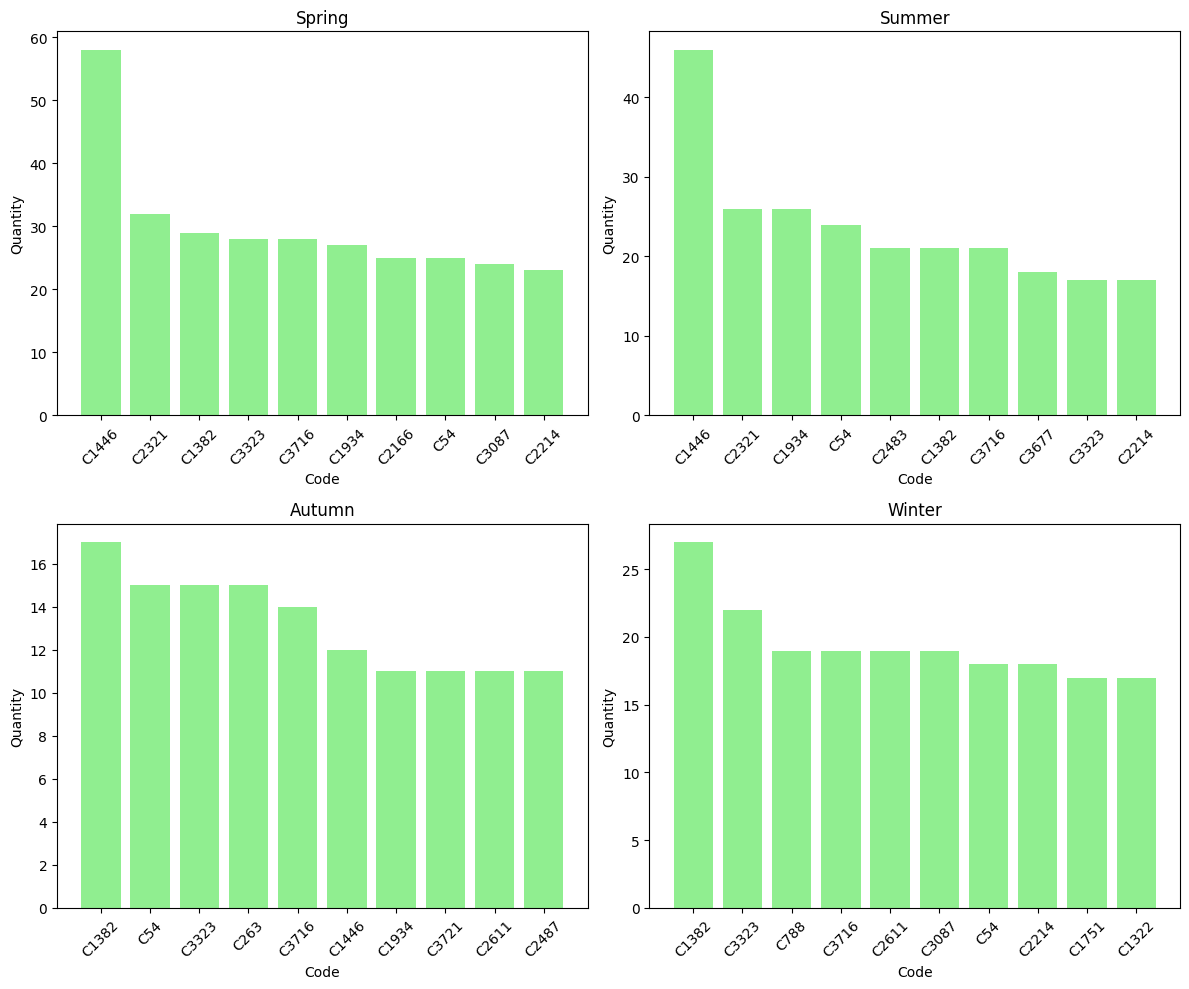

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

dataframes = [spring_dataset_counts_df, summer_dataset_counts_df, autumn_dataset_counts_df, winter_dataset_counts_df]
title = ['Spring', 'Summer', 'Autumn', 'Winter']

for i, ax in enumerate(axs.flat):
    df = pd.DataFrame(dataframes[i].sort_values(by='Quantity', ascending=False))
    ax.bar(df['Code'], df['Quantity'], color='lightgreen')
    ax.set_title(title[i])
    ax.set_xlabel('Code')
    ax.set_ylabel('Quantity')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

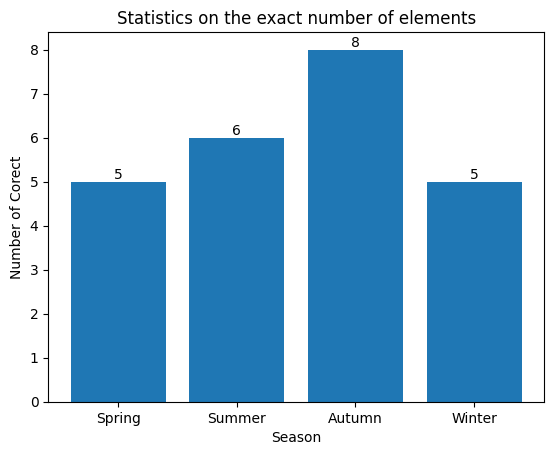

In [83]:
confident_spring_2022 = list(set(winter_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_spring_df['Code'])))

confident_summer_2022 = list(set(summer_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_summer_df['Code'])))

confident_autumn_2022 = list(set(autumn_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_autumn_df['Code'])))

confident_winter_2022 = list(set(winter_dataset_counts_df['Code']).intersection(set(Periodic_Frequent_winter_df['Code'])))



counts = [len(confident_spring_2022), len(confident_summer_2022), len(confident_autumn_2022), len(confident_winter_2022)]

# Vẽ biểu đồ cột
plt.bar(['Spring', 'Summer', 'Autumn', 'Winter'], counts)

# Add labels on top of each bar
plt.bar_label(plt.gca().containers[0])

plt.xlabel('Season')
plt.ylabel('Number of Corect')
plt.title('Statistics on the exact number of elements')
plt.show()


confident_dataset2 = sum([len(confident_spring_2022), len(confident_summer_2022), len(confident_autumn_2022), len(confident_winter_2022)]) /  4

In [84]:
confident_dataset2

6.0